## Корректор нарушений связи подлежащего и сказуемого

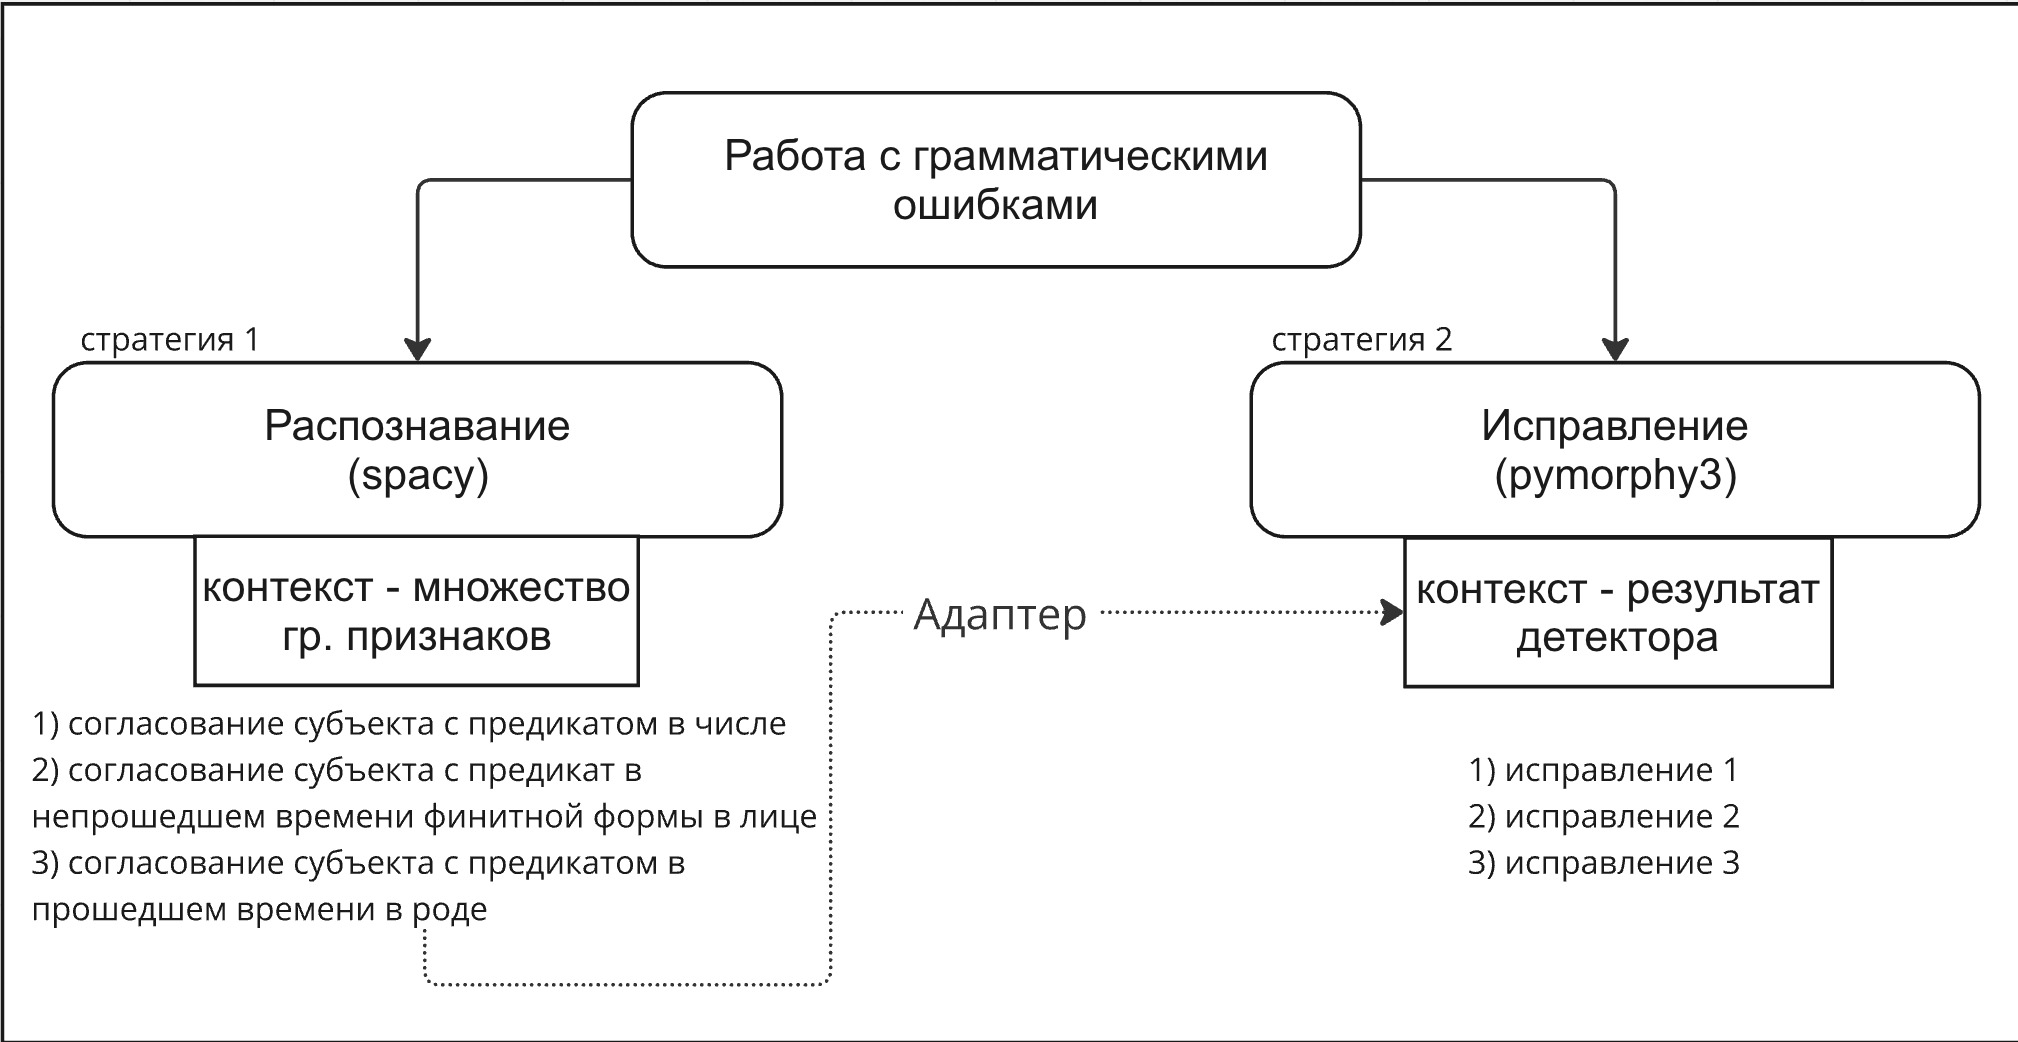

In [2]:
#@title Structure
from IPython.display import Image
Image('/Users/sergey/Downloads/structure.jpg', width = 700)

In [3]:
#@title Pip install
!pip install nltk
!pip install spacy
!pip install pymorphy3

In [4]:
#@title imports n' loads
import spacy
!python -m spacy download ru_core_news_lg
ru_nlp = spacy.load('ru_core_news_lg')
from abc import ABC, abstractmethod
import re
from pymorphy3 import MorphAnalyzer
import unittest
from unittest import TestCase
import os
#from nltk import Tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 691.0 kB/s eta 0:00:0000:0100:19
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


In [5]:
#@title ErrorTypes
class ErrorTypes():
  """Закрытый класс-хранилище типов ошибок."""

  def __init__(self):
    self.__error_types = {
        '0': 'No_mistake_found',
        '1': 'Number_error',
        '2': 'Gender_error',
        '3': 'Person_error'
    }

  @property
  def get_errors(self):
    return self.__error_types

In [6]:
#@title SpacyDependency
class SpacyDependency():
  """Класс грамматики зависимостей spacy."""

  def __init__(self):
    self.sentence = str()

  def build_dependency(self, sentence):
    """Принимает предложение и возвращает список словарей для каждого токена."""
    re.sub('/.{3}$|/.{1}$|[?!]+$', '', sentence)
    dependency_list = []
    for token in ru_nlp(sentence):
      dependency_dict = {}
      dependency_dict['lemma'] = token.lemma_
      dependency_dict['pos'] = token.pos_
      dependency_dict['token'] = token.text
      dependency_dict['dependence'] = token.dep_
      dependency_dict['head'] = token.head.text
      dependency_list.append(dependency_dict)
    return dependency_list


  def dependency_with_features(self, sentence):
    """Принимает предложение и возвращает список словарей для каждого токена, включая морфологические признаки."""
    dep_revisited = self.build_dependency(sentence)
    morphology_list = []
    for token in ru_nlp(sentence):
      morphology_list.append(token.morph.to_dict())
    assert len(dep_revisited) == len(morphology_list)
    for d1, d2 in zip(dep_revisited,morphology_list):
      d1['morphology'] = d2
    return dep_revisited

In [7]:
#@title BaseFinder
class BaseFinder():
  """Класс грамматических основ предложения."""

  def __init__(self):
    self.sentence = str()

  def get_predicate(self, sentence):
    """Принимает предложение и возвращает его предикат в формате словаря."""
    mydep = SpacyDependency()
    dep_dicts = mydep.dependency_with_features(sentence)
    predicate = [d for d in dep_dicts if 'dependence' in d and d['dependence'] == 'ROOT' and d['pos'] == 'VERB']
    return predicate[0]

  def get_subject(self, sentence):
    """Принимает предложение и возвращает его подлежащее в формате словаря."""
    mydep = SpacyDependency()
    dep_dicts = mydep.dependency_with_features(sentence)
    subject = [d for d in dep_dicts if 'dependence' in d and d['dependence'] == 'nsubj']
    return subject[0]

  def get_base(self,sentence):
    """Принимает предложение и возвращает его подлежащее и предикат в формате списка словарей."""
    base = [self.get_subject(sentence), self.get_predicate(sentence)]
    return base

In [8]:
#@title GrammarAdapter
class GrammarAdapter():
  """Класс-адаптер грамматики spacy под грамматику pymorphy3."""

  __sp_gender = {'Fem': 'femn','Masc': 'masc','Neut': 'neut'}
  __ps_gender = {'femn': 'Fem', 'masc': 'Masc', 'neut': 'Neut'}

  __sp_number = {'Sing' : 'sing', 'Plur': 'plur'}
  __ps_number = {'sing' : 'Sing', 'plur': 'Plur'}

  __sp_person = {'First': '1per', 'Second': '2per', 'Third': '3per'}
  __ps_person = {'1per': '', '2per': 'Second', '3per': 'Third'}

  def __init_(self):
    self.mydep = SpacyDependency()
    self.morph = MorphAnalyzer()

  def adapt_gender_sp(self, d: dict):
    """Принимает словарь и адаптирует обозначение рода для работы с pymorphy3."""
    try:
      d['morphology']['Gender'] = self.__sp_gender[f'{d["morphology"]["Gender"]}']
      return d
    except:
      print(f'{d["token"]} has no gender categorey')

  def adapt_gender_ps(self, d: dict):
    """Принимает словарь и адаптирует обозначение рода для работы с spacy."""
    try:
      d['morphology']['Gender'] = self.__ps_gender[f'{d["morphology"]["Gender"]}']
      return d
    except:
      print(f'{d["token"]} has no gender category')

  def adapt_number_sp(self, d: dict):
    """Принимает словарь и адаптирует обозначение числа для работы с pymorphy3."""
    d['morphology']['Number'] = self.__sp_number[f'{d["morphology"]["Number"]}']
    return d

  def adapt_number_ps(self, d: dict):
    """Принимает словарь и адаптирует обозначение числа для работы с spacy."""
    d['morphology']['Number'] = self.__ps_number[f'{d["morphology"]["Number"]}']
    return d

  def adapt_person_sp(self, d:dict):
    """Принимает словарь и адаптирует обозначение лица для работы с pymorphy3."""
    try:
      d['morpholoogy']['Person'] = self.__sp_person
    except:
      print(f'{d["token"]} has no person category')

  def adapt_person_ps(self, d:dict):
    """Принимает словарь и адаптирует обозначение лица для работы с spacy."""
    try:
      d['morpholoogy']['Person'] = self.__ps_person
    except:
      print(f'{d["token"]} has no person category')

In [9]:
GrammarAdapter().adapt_gender_ps(BaseFinder().get_predicate('Кто стоит'))

стоит has no gender category


In [10]:
#@title HomogeneousSubjects
class HomogeneousSubjects():
  """Класс однородных подлежащих."""

  @staticmethod
  def is_homogeneous(sentence):
    """Принимает предложение и проверяет наличие в нем однородных подлежащих."""
    mydep = SpacyDependency()
    dep_dicts = mydep.dependency_with_features(sentence)
    subject = BaseFinder().get_subject(sentence)['token']

    if [d for d in dep_dicts if 'dependence' in d and d['dependence'] == 'conj' and d['head'] == subject]:
      return True
    else:
      return False

In [11]:
#@title ComplexSentence:
class ComplexSentence():
  """Класс сложных предложений."""

  @staticmethod
  def is_complex(sentence):
    """Принимает предложение и проверяет, является ли оно сложным."""
    mydep = SpacyDependency()
    dep_dicts = mydep.dependency_with_features(sentence)
    subjects = []
    heads = []

    for d in dep_dicts:
      if d['dependence'] == 'nsubj':
        subjects.append(d)

    if len(subjects) > 1:
      for i in range(len(subjects)):
        if subjects[i]['head'] not in heads:
          heads.append(subjects[i]['head'])

    if len(heads) > 1:
      return True
    else:
      return False

In [12]:
ComplexSentence.is_complex('Все, кто слушал выступление профессора, удивился его речью.')

True

In [13]:
#@title ClassRegistry
class ClassRegistry(type):
  """Метакласс-хранилище стратегий обнаружения ошибок."""

  registry = []

  def __new__(cls, name, bases, attrs):
      new_class = super().__new__(cls, name, bases, attrs)
      if name not in [c.__name__ for c in cls.registry]:
          cls.registry.append(new_class)
      return new_class

  @classmethod
  def clear(cls):
    cls.registry = []

In [14]:
#@title GrammarDetector
class GrammarDetector(ABC):
  """Класс обнаружения грамматических ошибок."""

  @abstractmethod
  def detect(self, sentence):
    pass

In [15]:
#@title ContextDetector
class ContextDetector():
  """
  Класс контекста поиска ошибок. По умолчанию производится поиск всех ошибок (род, лицо, число).
  Следующим образом можно задать поиск конкретного типа ошиобк:
  - проверить число: SVNumberDetector()
  - провериц лицо: SVNonPastAgreementDetector()
  - проверить род: SVPastAgreementDetector()
  """

  def __init__(self, strategy = None):
    self._strategy = strategy

  @property
  def strategy(self) -> GrammarDetector:
    """Геттер стратегии."""
    return self._strategy

  @strategy.setter
  def strategy(self, strategy: GrammarDetector) -> None:
    """Сеттер стратегии."""
    self._strategy = strategy

  def execute_detector(self, sentence):
    """Принимает предложение и возвращает обнаруженные в нем ошибки. По умолчанию применяет все стратегии."""
    latin_letters = re.findall('[A-Za-z]',sentence)
    if len(latin_letters) != 0:
      return ('Извини, я умею работать только с русскими буквами!')

    if self._strategy == None:
      result = 'No_mistake_found'
      strategy = ClassRegistry.registry
      for strat in strategy:
        if strat.detect(sentence) != 'No_mistake_found' and strat.detect(sentence) != None:
          result = strat.detect(sentence)
      return result
    else:
      return self._strategy.detect(sentence)

In [16]:
#@title Combination of GrammarDetect and ClassRegistry
class GramRegCombined(GrammarDetector, ClassRegistry):
  pass

In [17]:
#@title SVPastAgreementDetector
class SVPastAgreementDetector(metaclass = GramRegCombined):
  """Класс ошибок в согласовании глаголов прошедшего времени с существительным-подлежащим."""

  @classmethod
  def detect(self, sentence):
    """Принимает предложение и проверяет его на наличие ошибок в согласовании. Возвращает тип обнаруженной ошибки."""
    basefinder = BaseFinder()
    predicate = basefinder.get_predicate(sentence)
    if predicate['morphology']['Tense'] == 'Past':
      subject = basefinder.get_subject(sentence)

      #проверяем наличие однородных подлежащих
      if HomogeneousSubjects.is_homogeneous(sentence):
        if predicate['morphology']['Number'] != 'Plur':
          return ErrorTypes().get_errors['1']

      #проверяем число и род
      if 'Number' in subject['morphology']:
        if predicate['morphology']['Number'] == subject['morphology']['Number']:
          if 'Gender' in subject['morphology']:
            if predicate['morphology']['Number'] == 'Sing' and predicate['morphology']['Gender'] == subject['morphology']['Gender']:
              return ErrorTypes().get_errors['0']
            elif predicate['morphology']['Number'] == 'Sing' and predicate['morphology']['Gender'] != subject['morphology']['Gender']:
              return ErrorTypes().get_errors['2']
        else:
          return ErrorTypes().get_errors['1']


In [18]:
SpacyDependency().dependency_with_features('Собака бегала по полю.')

[{'lemma': 'собака',
  'pos': 'NOUN',
  'token': 'Собака',
  'dependence': 'nsubj',
  'head': 'бегала',
  'morphology': {'Animacy': 'Anim',
   'Case': 'Nom',
   'Gender': 'Fem',
   'Number': 'Sing'}},
 {'lemma': 'бегать',
  'pos': 'VERB',
  'token': 'бегала',
  'dependence': 'ROOT',
  'head': 'бегала',
  'morphology': {'Aspect': 'Imp',
   'Gender': 'Fem',
   'Mood': 'Ind',
   'Number': 'Sing',
   'Tense': 'Past',
   'VerbForm': 'Fin',
   'Voice': 'Act'}},
 {'lemma': 'по',
  'pos': 'ADP',
  'token': 'по',
  'dependence': 'case',
  'head': 'полю',
  'morphology': {}},
 {'lemma': 'поле',
  'pos': 'NOUN',
  'token': 'полю',
  'dependence': 'obl',
  'head': 'бегала',
  'morphology': {'Animacy': 'Inan',
   'Case': 'Dat',
   'Gender': 'Neut',
   'Number': 'Sing'}},
 {'lemma': '.',
  'pos': 'PUNCT',
  'token': '.',
  'dependence': 'punct',
  'head': 'бегала',
  'morphology': {}}]

In [19]:
#@title SVNumberDetector
class SVNumberDetector(metaclass = GramRegCombined):
  """Класс нарушения согласования между подлежащим и предикатом в числе."""

  @classmethod
  def detect(self, sentence):
    """Принимает предложение и проверяет его на наличие ошибок в числе. Возвращает тип обнаруженной ошибки."""
    basefinder = BaseFinder()
    predicate = basefinder.get_predicate(sentence)
    subject = basefinder.get_subject(sentence)

    if HomogeneousSubjects.is_homogeneous(sentence):
      if predicate['morphology']['Number'] != 'Plur':
        return ErrorTypes().get_errors['1']

    elif subject['lemma'] == 'кто':
      if predicate['morphology']['Number'] != 'Sing':
          return ErrorTypes().get_errors['1']

    elif predicate['morphology']['Number'] != subject['morphology']['Number']:
      return ErrorTypes().get_errors['1']
    else:
      return ErrorTypes().get_errors['0']

In [20]:
#@title SVNonPastAgreementDetector
class SVNonPastAgreementDetector(metaclass = GramRegCombined):
  """Класс нарушения связи между подлежащим и сказуемым в лице."""

  @classmethod
  def detect(self, sentence):
    """Принимает предложение и проверяет его на наличие ошибок в лице. Возвращает тип обнаруженной ошибки."""
    basefinder = BaseFinder()
    predicate = basefinder.get_predicate(sentence)
    if predicate['morphology']['Tense'] == 'Pres' or predicate['morphology']['Tense'] == 'Fut':
      subject = basefinder.get_subject(sentence)

      if HomogeneousSubjects.is_homogeneous(sentence):
        if predicate['morphology']['Number'] != 'Plur':
          return ErrorTypes().get_errors['1']

      if predicate['morphology']['Number'] == subject['morphology']['Number']:

        if subject['pos'] == 'NOUN' and predicate['morphology']['Person'] != 'Third':
          return ErrorTypes().get_errors['3']
        else:
          return ErrorTypes().get_errors['0']

        if subject['pos'] == 'PRON':
          if subject['morphology']['person'] == predicate['morphology']['Person']:
            return ErrorTypes().get_errors['0']
          else:
            return ErrorTypes().get_errors['3']
      else:
        return ErrorTypes().get_errors['1']

In [21]:
#@title GrammarCorrector
class GrammarCorrector(ABC):
  """Класс исправления грамматических ошибок."""

  @abstractmethod
  def correct(self,sentence):
    pass

In [22]:
#@title SVGenderCorrector
class SVGenderCorrector(GrammarCorrector):
  """Класс исправления рода глагола."""

  def correct(self, sentence):
    """Принимает предложение с ошибкой и возвращает его исправленный вариант."""
    morph = MorphAnalyzer()
    mydep = SpacyDependency()

    subject, predicate = [el for el in BaseFinder().get_base(sentence)]
    subject = GrammarAdapter().adapt_gender_sp(subject)
    correct_gender = subject['morphology']['Gender']

    adapted_predicate = GrammarAdapter().adapt_gender_sp(predicate)
    for analysis in morph.parse(adapted_predicate['token']):
      if analysis.tag.POS == 'VERB':
        #target_form = morph.parse(adapted_predicate['token'])[0]
        correct_form = analysis.inflect({f'{correct_gender}', 'past', 'VERB'})[0]
        break
    #target_form = morph.parse(adapted_predicate['token'])[0]
    #correct_form = target_form.inflect({f'{correct_gender}'})[0]

    return re.sub(predicate['token'], correct_form, sentence)

In [23]:
#@title SVNumberCorrector
class SVNumberCorrector(GrammarCorrector):
  """Класс исправления числа глагола."""

  def correct(self, sentence):
    """Принимает предложение с ошибкой и возвращает его исправленный вариант."""
    morph = MorphAnalyzer()
    mydep = SpacyDependency()
    subject, predicate = [el for el in BaseFinder().get_base(sentence)]

    adapted_predicate = GrammarAdapter().adapt_number_sp(predicate)
    target_form = morph.parse(adapted_predicate['token'])[0]

    if HomogeneousSubjects.is_homogeneous(sentence):
      correct_form = target_form.inflect({'plur'})[0]
    elif subject['lemma'] == 'кто':
      correct_form = target_form.inflect({'sing'})[0]
    else:
      subject = GrammarAdapter().adapt_number_sp(subject)
      correct_number = subject['morphology']['Number']
      correct_form = target_form.inflect({f'{correct_number}'})[0]

    return re.sub(predicate['token'], correct_form, sentence)

In [24]:
#@title SVPersonCorrector
class SVPersonCorrector(GrammarCorrector):
  """Класс исправления лица глагола."""

  def correct(self, sentence):
    """Принимает предложение с ошибкой и возвращает его исправленный вариант."""
    morph = MorphAnalyzer()
    mydep = SpacyDependency()
    subject, predicate = [el for el in BaseFinder().get_base(sentence)]

    adapted_predicate = GrammarAdapter().adapt_number_sp(predicate)
    target_form = morph.parse(adapted_predicate['token'])[0]

    if subject['pos'] == 'NOUN' or subject['lemma'] == 'кто':
      correct_form = target_form.inflect({'3per'})[0]
    else :
      subject = GrammarAdapter().adapt_person_sp(subject)
      correct_person = subject['morphology']['Person']
      correct_form = target_form.inflect({f'{correct_person}'})[0]

    return re.sub(predicate['token'], correct_form, sentence)

In [25]:
#@title ContextCorrector
class ContextCorrector():
  """
  Класс контекста исправления ошибок. По умолчанию производится исправление всех ошибок (род, лицо, число).
  Следующим образом можно задать исправление (при наличии) конкретного типа ошиобк:
  - исправить число: SVNumberDetector()
  - исправить лицо: SVPersonCorrector()
  - исправить род: SVGenderCorrector()
  """

  def __init__(self, strategy = None):
    self._strategy = strategy

  def __repr__(self):
    """Возвращает представление объекта."""
    return 'Привет, я исправляю нарушения связи подлежащего и сказуемого!'

  @property
  def strategy(self) -> GrammarCorrector:
    """Геттер стратегии."""
    return self._strategy

  @strategy.setter
  def strategy(self, strategy: GrammarCorrector) -> None:
    """Сеттер стратегии."""
    self._strategy = strategy

  def execute_corrector(self,sentence):
    """Исправляет ошибки в предложении. По умолчанию исправляет все нарушения связи между подлежащим и сказуемым."""
    latin_letters = re.findall('[A-Za-z]',sentence)
    if len(latin_letters) != 0:
      return ('Извини, я умею работать только с русскими буквами!')
    try:
      if self._strategy != None:
        if ContextDetector().execute_detector(sentence) == 'No_mistake_found':
          return sentence
        else:
          return self._strategy.correct(sentence)

      else:
        for i in range(2):
          error_type = ContextDetector().execute_detector(sentence)
          if error_type == 'No_mistake_found':
            return sentence
          if error_type == 'Number_error':
            self._strategy = SVNumberCorrector()
          elif error_type == 'Gender_error':
            self._strategy = SVGenderCorrector()
          elif error_type == 'Person_error':
            self._strategy = SVPersonCorrector()
          sentence = self._strategy.correct(sentence)
          self._strategy = None
      return sentence
    except Exception:
      print('Ой! Это предложение слишком сложное для меня.')

In [26]:
mycorrector = ContextCorrector()
print(mycorrector.execute_corrector('Статья А.Баушева обратил на себя внимание курского губернатора, пожелавшего познакомиться с молодым автором'))
print(mycorrector.execute_corrector('Бабушка и дедушка пил вино в столовой на берегу моря.'))
print(mycorrector.execute_corrector('В фамусовском обществе ценится не только благородство и честность, а угодничество и подхалимство.'))
print(mycorrector.execute_corrector('Все, кто бывал в небольших городах Италии, видел каменные мосты, заросшие плющом, обветшалые старинные мраморные фасады зданий, мерцание позолоченных куполов.'))

Статья А.Баушева обратила на себя внимание курского губернатора, пожелавшего познакомиться с молодым автором
Бабушка и дедушка пили вино в столовой на берегу моря.
В фамусовском обществе ценятся не только благородство и честность, а угодничество и подхалимство.
Все, кто бывал в небольших городах Италии, видели каменные мосты, заросшие плющом, обветшалые старинные мраморные фасады зданий, мерцание позолоченных куполов.


Два списка предложений из ЕГЭ по русскому языку: один с ошибками, второй исправленный

## Юнит-тесты

In [31]:
#@title TestCorrector
class TestCorrector(TestCase):
    
    @classmethod
    def setUpClass(cls):
        with open('/Users/sergey/Downloads/wrongsentences.txt','r') as f:
            cls.wrong_sentences = f.readlines()
        with open('/Users/sergey/Downloads/correctsentences.txt','r') as f:
            cls.correct_sentences = f.readlines()
            
    @classmethod
    def tearDownClass(cls):
        if os.path.exists(cls.wrong_sentences) and os.path.exists(cls.correct_sentences):
            os.remove(cls.wrong_sentences)
            os.remove(cls.correct_sentences)
            
    def setUp(self):
        self.corrector = ContextCorrector()
        self.base = BaseFinder()
        self.adapter = GrammarAdapter()
        
    def homogeneity_check(self):
        self.assertTrue(self.HomogeneousSubjects.is_homogeneous('Собака и кошка бегали по полю.'))

    def test_number(self):
        self.assertEqual(self.corrector.execute_corrector('Собака бегают по полю.'), 'Собака бегает по полю.')

    def test_number_and_gender(self):
        self.assertEqual(self.corrector.execute_corrector('Собака бегали по полю.'),'Собака бегала по полю.')

    def test_homogeneous_subjects_verb(self):
        self.assertEqual(self.corrector.execute_corrector('Собака и кошка бегает по полю.'),'Собака и кошка бегают по полю.')

    def test_gender(self):
        self.assertEqual(self.corrector.execute_corrector('Собака бегал по полю.'), 'Собака бегала по полю.')

    def test_person(self):
        self.assertEqual(self.corrector.execute_corrector('Собака бегаешь по полю.'),'Собака бегает по полю.')

    def test_correct_sentences(self):
        self.assertEqual(self.corrector.execute_corrector('Собака бегает по полю.'),'Собака бегает по полю.')

    def test_wrong_language(self):
        self.assertEqual(self.corrector.execute_corrector('Vfvf xbnftn rybue.'),'Извини, я умею работать только с русскими буквами!')

    def test_ege(self):
        assert len(wrong_sentences) == len(correct_sentences), "Can't compare these lists"
        for i in range(len(wrong_sentences)):
            correction = self.corrector.execute_corrector(wrong_sentences[i])
            self.assertEqual(correction, correct_sentences[i])

In [32]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_correct_sentences (__main__.TestCorrector.test_correct_sentences) ... ok
test_ege (__main__.TestCorrector.test_ege) ... ok
test_gender (__main__.TestCorrector.test_gender) ... ok
test_homogeneous_subjects_verb (__main__.TestCorrector.test_homogeneous_subjects_verb) ... ok
test_number (__main__.TestCorrector.test_number) ... ok
test_number_and_gender (__main__.TestCorrector.test_number_and_gender) ... ok
test_person (__main__.TestCorrector.test_person) ... ok
test_wrong_language (__main__.TestCorrector.test_wrong_language) ... ok

----------------------------------------------------------------------
Ran 8 tests in 4.926s

OK
